

## Task 5: Project Overview and Goals
This notebook analyzes and compares the results from three distinct quantum walk simulations: an ideal binomial walk, an ideal exponential walk, and a binomial walk executed on a realistic noisy simulator.

The primary goal is to quantify the performance degradation caused by hardware noise and to measure the effectiveness of transpiler-based error mitigation as a strategy to improve simulation fidelity.





## Analysis and Verification Metrics
To provide a robust comparison, the obtained (experimental) probability distributions from each simulation are compared against their target (theoretical) distributions. The accuracy of each run is quantified using the following metrics:

###1. Hellinger Distance:
The Hellinger Distance is a true statistical metric used to measure the similarity between two probability distributions, P and Q. It is bounded between 0 (for identical distributions) and 1. It is the primary metric for evaluating performance in this analysis due to its symmetric nature.

$$H(P, Q) = \frac{1}{\sqrt{2}} \sqrt{\sum_{i} (\sqrt{p_i} - \sqrt{q_i})^2}$$


###2. Stochastic Uncertainty Analysi:
Because each simulation is run for a finite number of shots (e.g., 8192), there is inherent statistical randomness in the results, known as shot noise. To distinguish this random error from real error caused by hardware noise, we calculate the stochastic uncertainty using the bootstrapping method. This analysis provides error bars for our Hellinger Distance measurements, allowing us to determine if the observed differences are statistically significant.

--- Running All Quantum Walk Simulations ---
Starting ideal binomial simulation...
Ideal binomial simulation completed in: 0.24 seconds
Starting ideal exponential simulation...
Ideal exponential simulation completed in: 4.89 seconds
Running baseline noisy simulation...
Baseline simulation executed in: 0.30 seconds
Running optimized noisy simulation...
Optimized simulation executed in: 0.32 seconds
All simulations complete.

--- Task 5: Distribution Distance and Uncertainty Analysis ---

Simulation: Ideal Binomial
  - Hellinger Distance: 0.005773 ± 0.003021
  - KL Divergence:      0.000133

Simulation: Ideal Exponential
  - Hellinger Distance: 0.007851 ± 0.001650
  - KL Divergence:      0.000162

Simulation: Noisy Baseline
  - Hellinger Distance: 0.017108 ± 0.003668
  - KL Divergence:      0.001175

Simulation: Optimized Noisy
  - Hellinger Distance: 0.008682 ± 0.003226
  - KL Divergence:      0.000303


Final report saved to final_report.txt


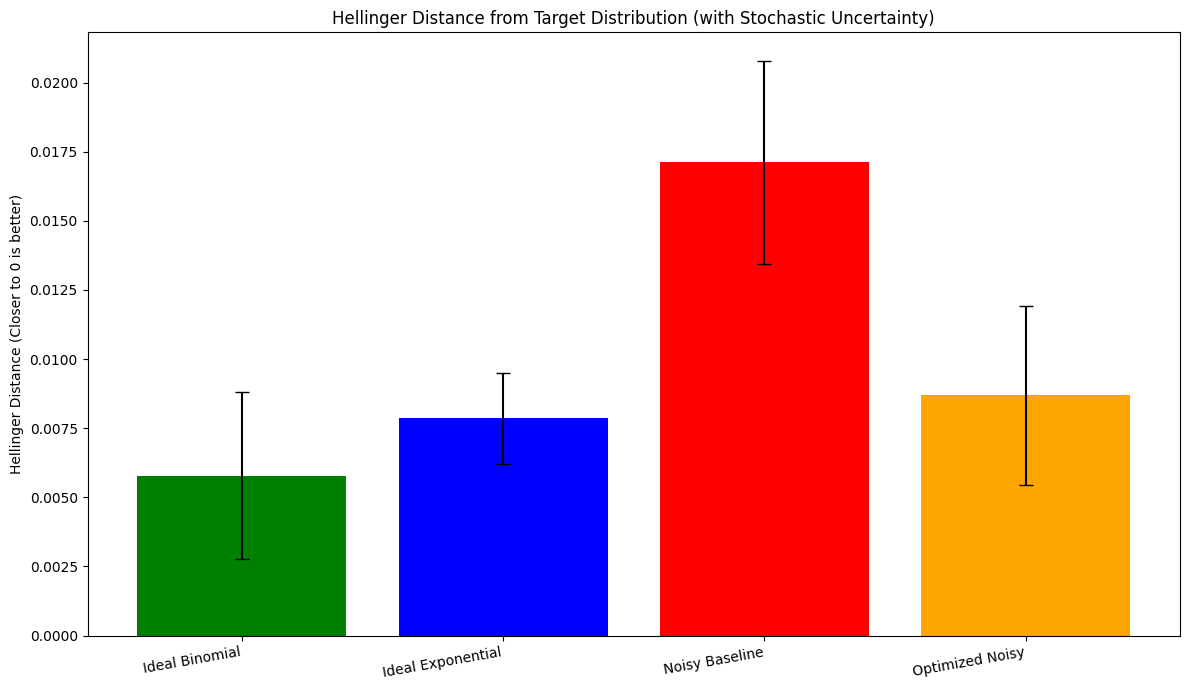

Comparison plot saved to hellinger_comparison.png


In [ ]:
import sys
sys.path.append('../')
#1. IMPORT LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom, entropy

# Import the custom functions for quantum simulations
from src.ideal_binomial import run_ideal_binomial_simulation
from src.ideal_exponential import run_ideal_exponential_simulation
from src.noisy import run_noisy_baseline, run_optimized_simulation

#2. HELPER AND ANALYSIS FUNCTIONS
def convert_counts_to_probs(counts_dict, n_layers):
    """
    Converts a dictionary of position counts into a NumPy array of probabilities.
    This is a crucial data processing step to prepare results for analysis.

    Args:
        counts_dict (dict): A dictionary of position counts from a simulation.
        n_layers (int): The number of layers used in the simulation.

    Returns:
        np.array: A NumPy array representing the final probability distribution.
    """
    total_shots = sum(counts_dict.values())
    if total_shots == 0:
        return np.zeros(n_layers + 1)

    outcomes = np.arange(n_layers + 1)
    probs = np.array([counts_dict.get(i, 0) / total_shots for i in outcomes])
    return probs

def calculate_hellinger_distance(p, q):
    """
    Computes the Hellinger distance between two probability distributions.
    This is a true symmetric metric, bounded between 0 (identical) and 1.

    Args:
        p (np.array): The first probability distribution.
        q (np.array): The second probability distribution.

    Returns:
        float: The calculated Hellinger distance.
    """
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / np.sqrt(2)

def calculate_kl_divergence(p, q):
    """
    Computes the Kullback-Leibler (KL) divergence.

    Args:
        p (np.array): The obtained probability distribution.
        q (np.array): The target probability distribution.

    Returns:
        float: The calculated KL divergence.
    """
    # Add a small epsilon (1e-10) to the target distribution to avoid log(0) errors.
    return entropy(pk=p, qk=q + 1e-10)

def get_stochastic_uncertainty(p_obtained, p_target, n_shots=8192, num_resamples=1000):
    """
    Calculates the stochastic uncertainty (shot noise) of the Hellinger distance
    using the bootstrapping method. This fulfills the final part of Task 5.

    Args:
        p_obtained (np.array): The probability distribution from a single simulation.
        p_target (np.array): The ideal, theoretical probability distribution.
        n_shots (int): The number of shots used in the original simulation.
        num_resamples (int): The number of bootstrap samples to generate.

    Returns:
        float: The standard deviation of the bootstrapped Hellinger distances,
               representing the 1-sigma uncertainty.
    """
    hellinger_distances = []
    num_outcomes = len(p_obtained)
    for _ in range(num_resamples):
        # Create a new "fake" experiment by resampling from the obtained distribution
        resampled_counts = np.random.choice(num_outcomes, size=n_shots, p=p_obtained)
        resampled_probs = np.bincount(resampled_counts, minlength=num_outcomes) / n_shots
        dist = calculate_hellinger_distance(resampled_probs, p_target)
        hellinger_distances.append(dist)
    return np.std(hellinger_distances)

def get_target_binomial_dist(n_layers):
    """Returns the theoretical binomial distribution B(n, 0.5)."""
    return binom.pmf(np.arange(n_layers + 1), n_layers, 0.5)

def get_target_exponential_dist(n_layers, p_right=0.2):
    """Returns the theoretical skewed binomial distribution B(n, p_right)."""
    return binom.pmf(np.arange(n_layers + 1), n_layers, p_right)

# MAIN EXECUTION SCRIPT

if __name__ == "__main__":
    # --- SETUP: Define simulation parameters ---
    N_LAYERS = 8
    N_SHOTS_IDEAL = 8192
    N_SHOTS_EXP = 16384
    N_SHOTS_NOISY = 8192

    # --- RUN SIMULATIONS: Gather all experimental data ---
    print("--- Running All Quantum Walk Simulations ---")
    ideal_binomial_counts = run_ideal_binomial_simulation(N_LAYERS, N_SHOTS_IDEAL)
    ideal_exp_counts = run_ideal_exponential_simulation(N_LAYERS, N_SHOTS_EXP)
    noisy_baseline_counts, optimized_noisy_counts = run_noisy_baseline(N_LAYERS, N_SHOTS_NOISY), run_optimized_simulation(N_LAYERS, N_SHOTS_NOISY)
    print("All simulations complete.\n")

    # --- PROCESS DATA: Convert raw counts to probability arrays ---
    sim_probabilities = {
        "Ideal Binomial": convert_counts_to_probs(ideal_binomial_counts, N_LAYERS),
        "Ideal Exponential": convert_counts_to_probs(ideal_exp_counts, N_LAYERS),
        "Noisy Baseline": convert_counts_to_probs(noisy_baseline_counts, N_LAYERS),
        "Optimized Noisy": convert_counts_to_probs(optimized_noisy_counts, N_LAYERS)
    }

    # --- GET TARGETS: Generate the theoretical distributions for comparison ---
    target_distributions = {
        "Ideal Binomial": get_target_binomial_dist(N_LAYERS),
        "Ideal Exponential": get_target_exponential_dist(N_LAYERS),
        "Noisy Baseline": get_target_binomial_dist(N_LAYERS),
        "Optimized Noisy": get_target_binomial_dist(N_LAYERS)
    }

    # --- ANALYZE & REPORT: Compute distances and uncertainties for each run ---
    analysis_output = {}
    report = "--- Task 5: Distribution Distance and Uncertainty Analysis ---\n\n"

    for name, p_obt in sim_probabilities.items():
        p_tgt = target_distributions[name]
        # Adjust shot count for the exponential simulation for accurate uncertainty
        n_shots = N_SHOTS_EXP if name == "Ideal Exponential" else N_SHOTS_IDEAL

        # Calculate all metrics
        hellinger = calculate_hellinger_distance(p_obt, p_tgt)
        kl_div = calculate_kl_divergence(p_obt, p_tgt)
        uncertainty = get_stochastic_uncertainty(p_obt, p_tgt, n_shots)

        analysis_output[name] = {"hellinger": hellinger, "uncertainty": uncertainty}

        # Format the report string
        report += f"Simulation: {name}\n"
        report += f"  - Hellinger Distance: {hellinger:.6f} ± {uncertainty:.6f}\n"
        report += f"  - KL Divergence:      {kl_div:.6f}\n\n"

    print(report)
    with open("final_report.txt", "w") as f:
        f.write(report)
    print("Final report saved to final_report.txt")

    # --- VISUALIZE RESULTS: Generate and save the final comparison plot ---
    sim_names = list(analysis_output.keys())
    hellinger_values = [res['hellinger'] for res in analysis_output.values()]
    error_bars = [res['uncertainty'] for res in analysis_output.values()]

    plt.figure(figsize=(12, 7))
    plt.bar(sim_names, hellinger_values, yerr=error_bars, capsize=5,
            color=['green', 'blue', 'red', 'orange'])
    plt.ylabel("Hellinger Distance (Closer to 0 is better)")
    plt.title("Hellinger Distance from Target Distribution (with Stochastic Uncertainty)")
    plt.xticks(rotation=10, ha="right")
    plt.tight_layout()
    plt.savefig("hellinger_comparison.png")
    plt.show()
    print("Comparison plot saved to hellinger_comparison.png")